In [1]:
pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow_examples.models.pix2pix import pix2pix
tfds.disable_progress_bar()

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info = True,
                              as_supervised = True)


train_h, train_z = dataset['trainA'], dataset['trainB']
test_h, test_z = dataset['testA'], dataset['testB']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete76DYJT/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete76DYJT/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete76DYJT/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete76DYJT/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

#same pre-processing as done in pix2pix, with random mirroring and jittering

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

  #between -1 and 1

In [8]:
def random_jitter(image):
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = random_crop(image)  #crop it back to (256, 256)

  image = tf.image.random_flip_left_right(image)

  return image


In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
#load samples from the dataset through parallelism where we will take in batches and maintain a buffer to shuffle and sample from

train_h = train_h.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_z = train_z.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_h = test_h.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_z = test_z.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [12]:
sample_h = next(iter(train_h))
sample_z = next(iter(train_z))

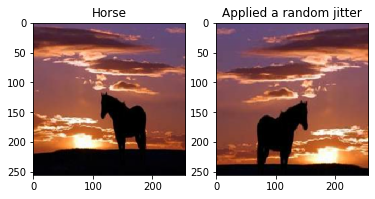

In [13]:
#to pass it to imshow we re-normalize to 0-1

#show the jitter that has been performed

plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_h[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Applied a random jitter')
plt.imshow(random_jitter(sample_h[0]) * 0.5 + 0.5)


In [14]:
#the model is very similar to the pix2pix , load each G and the D from the tensorflow_examples package
#note the few changes in the model
#paper uses mod-resnet but we use a mod-UNet for the sake of simplicity

out_channels = 3
generator_G = pix2pix.unet_generator(output_channels=out_channels, norm_type = 'instancenorm')
generator_F = pix2pix.unet_generator(output_channels=out_channels, norm_type = 'instancenorm')

discriminator_X = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)


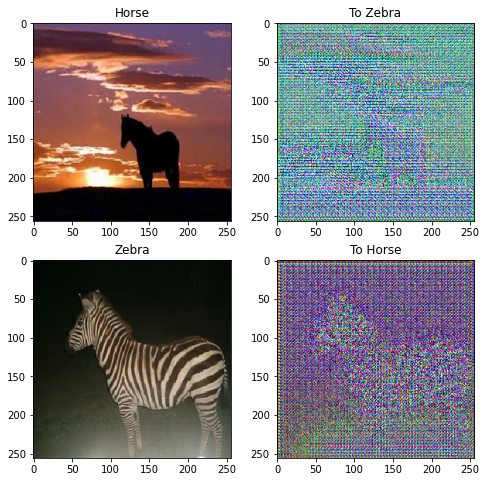

In [15]:
#display the class of img that we require and also the starting image generated before we start the training process

to_z = generator_G(sample_h)
to_h = generator_F(sample_z)
plt.figure(figsize = (8, 8))
contrast = 8

imgs = [sample_h, to_z, sample_z, to_h]

title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

#display the actual image with extra contrast while we plot

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()



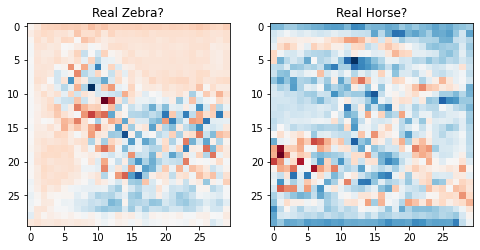

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Real Zebra?')
plt.imshow(discriminator_Y(sample_z)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Real Horse?')
plt.imshow(discriminator_X(sample_h)[0, ..., -1], cmap='RdBu_r')

plt.show()
#30x30 output is obtained and each path will cover a 70x70 region of the input image, classify as fake or real

In [17]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)
lambda_val = 10

# **Adversarial Losses**

In [18]:
def generator_loss(generated):
  return loss_fn(tf.ones_like(generated), generated)

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_fn(tf.ones_like(real), real)

  generated_loss = loss_fn(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

# **Cycle Consistency Losses**

In [20]:
def calc_cycle_loss(real_image, cycled_image):
  loss = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
  return lambda_val * loss

# **Identity Loss**

As shown above, generator G is responsible for translating image X to image Y. Identity loss says that, if you fed image Y to generator G, it should yield the real image Y or something close to image Y.


In [21]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return lambda_val * 0.5 * loss

In [22]:
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [23]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_G = generator_G,
                           generator_F = generator_F,
                           discriminator_X = discriminator_X,
                           discriminator_Y = discriminator_Y,
                           generator_G_optimizer = generator_G_optimizer,
                           generator_F_optimizer = generator_F_optimizer,
                           discriminator_X_optimizer = discriminator_X_optimizer,
                           discriminator_Y_optimizer = discriminator_Y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [28]:
EPOCHS = 40

def generate_images(model, test_image):
  prediction = model(test_image) #pass in the generator as the model when we train to see how accurate the generated images are
    
  plt.figure(figsize=(14, 14))

  images =  [test_image[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # normalize between [0, 1] to plot it
    plt.imshow(images[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

# **Training**
    - Get the predictions.
    - Calculate the loss.
    - Calculate the gradients using backpropagation.
    - Apply the gradients to the optimizer.


In [33]:
@tf.function
def train_step(real_x, real_y):

  with tf.GradientTape(persistent = True) as tape:  #persistent is true as gradient is used over once to calculate the gradients

    fake_y = generator_G(real_x, training = True)
    cycled_x = generator_F(fake_y, training = True)

    fake_x = generator_G(real_y, training = True)
    cycled_y = generator_F(fake_x, training = True)    

    #for the identity loss function
    same_x = generator_F(real_x, training = True)
    same_y = generator_G(real_y, training = True)

    disc_real_x = discriminator_X(real_x, training = True)
    disc_real_y = discriminator_Y(real_y, training = True)

    disc_fake_x = discriminator_X(fake_x, training = True)
    disc_fake_y = discriminator_Y(fake_y, training = True)

    gen_G_loss = generator_loss(disc_fake_y)
    gen_F_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)


    # Calculate the gradients for generator and discriminator
  generator_G_gradients = tape.gradient(total_gen_G_loss, 
                                        generator_G.trainable_variables)
  generator_F_gradients = tape.gradient(total_gen_F_loss, 
                                        generator_F.trainable_variables)
  
  discriminator_X_gradients = tape.gradient(disc_X_loss, 
                                            discriminator_X.trainable_variables)
  discriminator_Y_gradients = tape.gradient(disc_Y_loss, 
                                            discriminator_Y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_G_optimizer.apply_gradients(zip(generator_G_gradients, 
                                            generator_G.trainable_variables))

  generator_F_optimizer.apply_gradients(zip(generator_F_gradients, 
                                            generator_F.trainable_variables))
  
  discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients,
                                                discriminator_X.trainable_variables))
  
  discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients,
                                                discriminator_Y.trainable_variables))




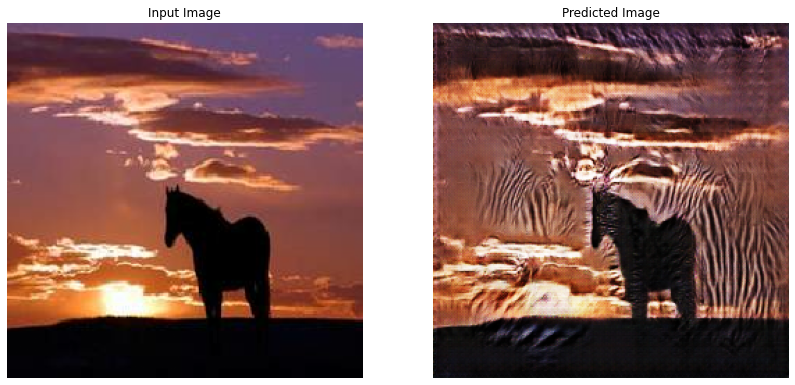

Time taken for epoch 34 is 459.01297187805176 sec

................................................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_h, train_z)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_h) to note progress

  generate_images(generator_G, sample_h)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


In [ ]:
for input_img in test_horses.take(5):
  generate_images(generator_G, input_img)